In [12]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as psnr
import cv2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [13]:



# Dataset pour le débruitage
class DenoisingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = [
            os.path.join(root_dir, img) for img in os.listdir(root_dir)
            if img.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))
        ]
        if not self.image_paths:
            raise ValueError(f"Aucune image valide trouvée dans le répertoire: {root_dir}")
        self.transform = transform

    def add_gaussian_noise(self, image, mean=0, std=0.3):
        noise = torch.randn_like(image) * std + mean
        return torch.clamp(image + noise, 0, 1)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        noisy_image = self.add_gaussian_noise(image)
        return noisy_image, image


# Transformations pour le dataset
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Chargement du dataset BSD500
train_dataset = DenoisingDataset(root_dir='archive/images/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)




In [14]:
# Définition du générateur (CGNet)
class CGNet(nn.Module):
    def __init__(self):
        super(CGNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        return self.model(x)


# Définition du discriminateur
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        x = torch.mean(x, dim=(2, 3))  # Global average pooling
        return self.sigmoid(x)




In [15]:
# Initialisation des modèles
generator = CGNet().to(device)
discriminator = Discriminator().to(device)

# Critères et optimiseurs
pixelwise_loss = nn.MSELoss()
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

# Entraînement
num_epochs = 100
for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    for noisy_imgs, clean_imgs in tqdm(train_loader):
        noisy_imgs = noisy_imgs.to(device)
        clean_imgs = clean_imgs.to(device)

        # Labels pour le discriminateur
        batch_size = noisy_imgs.size(0)
        valid = torch.ones((batch_size, 1), device=device, requires_grad=False)
        fake = torch.zeros((batch_size, 1), device=device, requires_grad=False)

        # ----- Mise à jour du générateur -----
        optimizer_G.zero_grad()
        generated_imgs = generator(noisy_imgs)
        g_loss_pixelwise = pixelwise_loss(generated_imgs, clean_imgs)
        g_loss_adversarial = adversarial_loss(discriminator(generated_imgs), valid)
        g_loss = 0.001 * g_loss_adversarial + g_loss_pixelwise
        g_loss.backward()
        optimizer_G.step()

        # ----- Mise à jour du discriminateur -----
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(clean_imgs), valid)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Generator Loss: {g_loss.item():.4f} | Discriminator Loss: {d_loss.item():.4f}")

# Sauvegarde des modèles
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.05it/s]


Epoch [1/100] | Generator Loss: 0.0485 | Discriminator Loss: 0.3673


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.10it/s]


Epoch [2/100] | Generator Loss: 0.0369 | Discriminator Loss: 0.2585


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.14it/s]


Epoch [3/100] | Generator Loss: 0.0225 | Discriminator Loss: 0.1254


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.98it/s]


Epoch [4/100] | Generator Loss: 0.0145 | Discriminator Loss: 0.1011


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.13it/s]


Epoch [5/100] | Generator Loss: 0.0160 | Discriminator Loss: 0.1709


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.03it/s]


Epoch [6/100] | Generator Loss: 0.0107 | Discriminator Loss: 0.1261


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.99it/s]


Epoch [7/100] | Generator Loss: 0.0090 | Discriminator Loss: 0.1067


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.03it/s]


Epoch [8/100] | Generator Loss: 0.0107 | Discriminator Loss: 0.1067


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.83it/s]


Epoch [9/100] | Generator Loss: 0.0100 | Discriminator Loss: 0.0473


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.96it/s]


Epoch [10/100] | Generator Loss: 0.0105 | Discriminator Loss: 0.0352


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.84it/s]


Epoch [11/100] | Generator Loss: 0.0107 | Discriminator Loss: 0.0222


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.92it/s]


Epoch [12/100] | Generator Loss: 0.0112 | Discriminator Loss: 0.0364


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.99it/s]


Epoch [13/100] | Generator Loss: 0.0104 | Discriminator Loss: 0.0485


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.92it/s]


Epoch [14/100] | Generator Loss: 0.0079 | Discriminator Loss: 0.1698


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.93it/s]


Epoch [15/100] | Generator Loss: 0.0098 | Discriminator Loss: 0.2060


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.93it/s]


Epoch [16/100] | Generator Loss: 0.0074 | Discriminator Loss: 0.2893


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.91it/s]


Epoch [17/100] | Generator Loss: 0.0091 | Discriminator Loss: 0.2950


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


Epoch [18/100] | Generator Loss: 0.0079 | Discriminator Loss: 0.4872


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.93it/s]


Epoch [19/100] | Generator Loss: 0.0082 | Discriminator Loss: 0.4097


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.87it/s]


Epoch [20/100] | Generator Loss: 0.0077 | Discriminator Loss: 0.4554


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


Epoch [21/100] | Generator Loss: 0.0075 | Discriminator Loss: 0.5204


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.80it/s]


Epoch [22/100] | Generator Loss: 0.0070 | Discriminator Loss: 0.6913


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.86it/s]


Epoch [23/100] | Generator Loss: 0.0070 | Discriminator Loss: 0.3261


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.97it/s]


Epoch [24/100] | Generator Loss: 0.0068 | Discriminator Loss: 0.3044


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.87it/s]


Epoch [25/100] | Generator Loss: 0.0084 | Discriminator Loss: 0.3360


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.94it/s]


Epoch [26/100] | Generator Loss: 0.0073 | Discriminator Loss: 0.2991


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.90it/s]


Epoch [27/100] | Generator Loss: 0.0083 | Discriminator Loss: 0.3456


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.91it/s]


Epoch [28/100] | Generator Loss: 0.0070 | Discriminator Loss: 0.3304


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


Epoch [29/100] | Generator Loss: 0.0077 | Discriminator Loss: 0.4925


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.97it/s]


Epoch [30/100] | Generator Loss: 0.0077 | Discriminator Loss: 0.2575


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.99it/s]


Epoch [31/100] | Generator Loss: 0.0069 | Discriminator Loss: 0.2567


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.08it/s]


Epoch [32/100] | Generator Loss: 0.0067 | Discriminator Loss: 0.5296


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


Epoch [33/100] | Generator Loss: 0.0074 | Discriminator Loss: 0.2402


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.97it/s]


Epoch [34/100] | Generator Loss: 0.0068 | Discriminator Loss: 0.2471


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.95it/s]


Epoch [35/100] | Generator Loss: 0.0073 | Discriminator Loss: 0.2987


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.77it/s]


Epoch [36/100] | Generator Loss: 0.0085 | Discriminator Loss: 0.3748


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.93it/s]


Epoch [37/100] | Generator Loss: 0.0078 | Discriminator Loss: 0.2032


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.96it/s]


Epoch [38/100] | Generator Loss: 0.0079 | Discriminator Loss: 0.1538


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.97it/s]


Epoch [39/100] | Generator Loss: 0.0093 | Discriminator Loss: 0.3729


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.97it/s]


Epoch [40/100] | Generator Loss: 0.0081 | Discriminator Loss: 0.3530


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.88it/s]


Epoch [41/100] | Generator Loss: 0.0081 | Discriminator Loss: 0.3072


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


Epoch [42/100] | Generator Loss: 0.0089 | Discriminator Loss: 0.4478


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.56it/s]


Epoch [43/100] | Generator Loss: 0.0070 | Discriminator Loss: 0.2239


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


Epoch [44/100] | Generator Loss: 0.0080 | Discriminator Loss: 0.1865


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.47it/s]


Epoch [45/100] | Generator Loss: 0.0079 | Discriminator Loss: 0.1759


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.89it/s]


Epoch [46/100] | Generator Loss: 0.0082 | Discriminator Loss: 0.3077


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.83it/s]


Epoch [47/100] | Generator Loss: 0.0082 | Discriminator Loss: 0.4046


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.88it/s]


Epoch [48/100] | Generator Loss: 0.0093 | Discriminator Loss: 0.4181


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.89it/s]


Epoch [49/100] | Generator Loss: 0.0078 | Discriminator Loss: 0.1297


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.87it/s]


Epoch [50/100] | Generator Loss: 0.0080 | Discriminator Loss: 0.1195


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.86it/s]


Epoch [51/100] | Generator Loss: 0.0081 | Discriminator Loss: 0.1368


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.88it/s]


Epoch [52/100] | Generator Loss: 0.0087 | Discriminator Loss: 0.4151


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.88it/s]


Epoch [53/100] | Generator Loss: 0.0085 | Discriminator Loss: 0.1168


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.88it/s]


Epoch [54/100] | Generator Loss: 0.0080 | Discriminator Loss: 0.1340


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.86it/s]


Epoch [55/100] | Generator Loss: 0.0082 | Discriminator Loss: 0.2056


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.88it/s]


Epoch [56/100] | Generator Loss: 0.0076 | Discriminator Loss: 0.1365


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.88it/s]


Epoch [57/100] | Generator Loss: 0.0083 | Discriminator Loss: 0.2101


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.88it/s]


Epoch [58/100] | Generator Loss: 0.0077 | Discriminator Loss: 0.0755


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.86it/s]


Epoch [59/100] | Generator Loss: 0.0072 | Discriminator Loss: 0.1922


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.88it/s]


Epoch [60/100] | Generator Loss: 0.0100 | Discriminator Loss: 0.3429


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.54it/s]


Epoch [61/100] | Generator Loss: 0.0080 | Discriminator Loss: 0.1083


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


Epoch [62/100] | Generator Loss: 0.0091 | Discriminator Loss: 0.0788


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.89it/s]


Epoch [63/100] | Generator Loss: 0.0086 | Discriminator Loss: 0.1204


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


Epoch [64/100] | Generator Loss: 0.0074 | Discriminator Loss: 0.1037


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.00it/s]


Epoch [65/100] | Generator Loss: 0.0075 | Discriminator Loss: 0.0418


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.13it/s]


Epoch [66/100] | Generator Loss: 0.0086 | Discriminator Loss: 0.1329


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.15it/s]


Epoch [67/100] | Generator Loss: 0.0064 | Discriminator Loss: 0.5774


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.11it/s]


Epoch [68/100] | Generator Loss: 0.0069 | Discriminator Loss: 0.1380


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.01it/s]


Epoch [69/100] | Generator Loss: 0.0086 | Discriminator Loss: 0.2530


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.82it/s]


Epoch [70/100] | Generator Loss: 0.0078 | Discriminator Loss: 0.1259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


Epoch [71/100] | Generator Loss: 0.0084 | Discriminator Loss: 0.2304


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.86it/s]


Epoch [72/100] | Generator Loss: 0.0085 | Discriminator Loss: 0.1304


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.76it/s]


Epoch [73/100] | Generator Loss: 0.0091 | Discriminator Loss: 0.1162


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


Epoch [74/100] | Generator Loss: 0.0081 | Discriminator Loss: 0.1471


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.76it/s]


Epoch [75/100] | Generator Loss: 0.0075 | Discriminator Loss: 0.2427


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


Epoch [76/100] | Generator Loss: 0.0088 | Discriminator Loss: 0.0665


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


Epoch [77/100] | Generator Loss: 0.0083 | Discriminator Loss: 0.1820


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


Epoch [78/100] | Generator Loss: 0.0104 | Discriminator Loss: 0.1590


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.76it/s]


Epoch [79/100] | Generator Loss: 0.0100 | Discriminator Loss: 0.0885


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.93it/s]


Epoch [80/100] | Generator Loss: 0.0090 | Discriminator Loss: 0.1689


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.95it/s]


Epoch [81/100] | Generator Loss: 0.0098 | Discriminator Loss: 0.0281


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


Epoch [82/100] | Generator Loss: 0.0082 | Discriminator Loss: 0.1051


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.93it/s]


Epoch [83/100] | Generator Loss: 0.0080 | Discriminator Loss: 0.1460


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.50it/s]


Epoch [84/100] | Generator Loss: 0.0084 | Discriminator Loss: 0.0371


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.86it/s]


Epoch [85/100] | Generator Loss: 0.0087 | Discriminator Loss: 0.0296


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.88it/s]


Epoch [86/100] | Generator Loss: 0.0099 | Discriminator Loss: 0.3276


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.90it/s]


Epoch [87/100] | Generator Loss: 0.0118 | Discriminator Loss: 0.1044


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.56it/s]


Epoch [88/100] | Generator Loss: 0.0084 | Discriminator Loss: 0.1089


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.77it/s]


Epoch [89/100] | Generator Loss: 0.0099 | Discriminator Loss: 0.2013


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.86it/s]


Epoch [90/100] | Generator Loss: 0.0088 | Discriminator Loss: 0.0829


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.76it/s]


Epoch [91/100] | Generator Loss: 0.0075 | Discriminator Loss: 0.1190


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.62it/s]


Epoch [92/100] | Generator Loss: 0.0068 | Discriminator Loss: 0.2865


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.87it/s]


Epoch [93/100] | Generator Loss: 0.0082 | Discriminator Loss: 0.0716


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


Epoch [94/100] | Generator Loss: 0.0102 | Discriminator Loss: 0.1950


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


Epoch [95/100] | Generator Loss: 0.0102 | Discriminator Loss: 0.0393


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


Epoch [96/100] | Generator Loss: 0.0081 | Discriminator Loss: 0.0961


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


Epoch [97/100] | Generator Loss: 0.0092 | Discriminator Loss: 0.0173


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.85it/s]


Epoch [98/100] | Generator Loss: 0.0102 | Discriminator Loss: 0.0307


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


Epoch [99/100] | Generator Loss: 0.0103 | Discriminator Loss: 0.0380


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]

Epoch [100/100] | Generator Loss: 0.0093 | Discriminator Loss: 0.0773


In [18]:
torch.save(generator, 'generator.pth')
torch.save(discriminator, 'discriminator.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.19389042..1.1891545].


PSNR Noisy: 11.97, PSNR Generated: 23.70, PSNR Refined: 21.88, PSNR Fused: 22.97


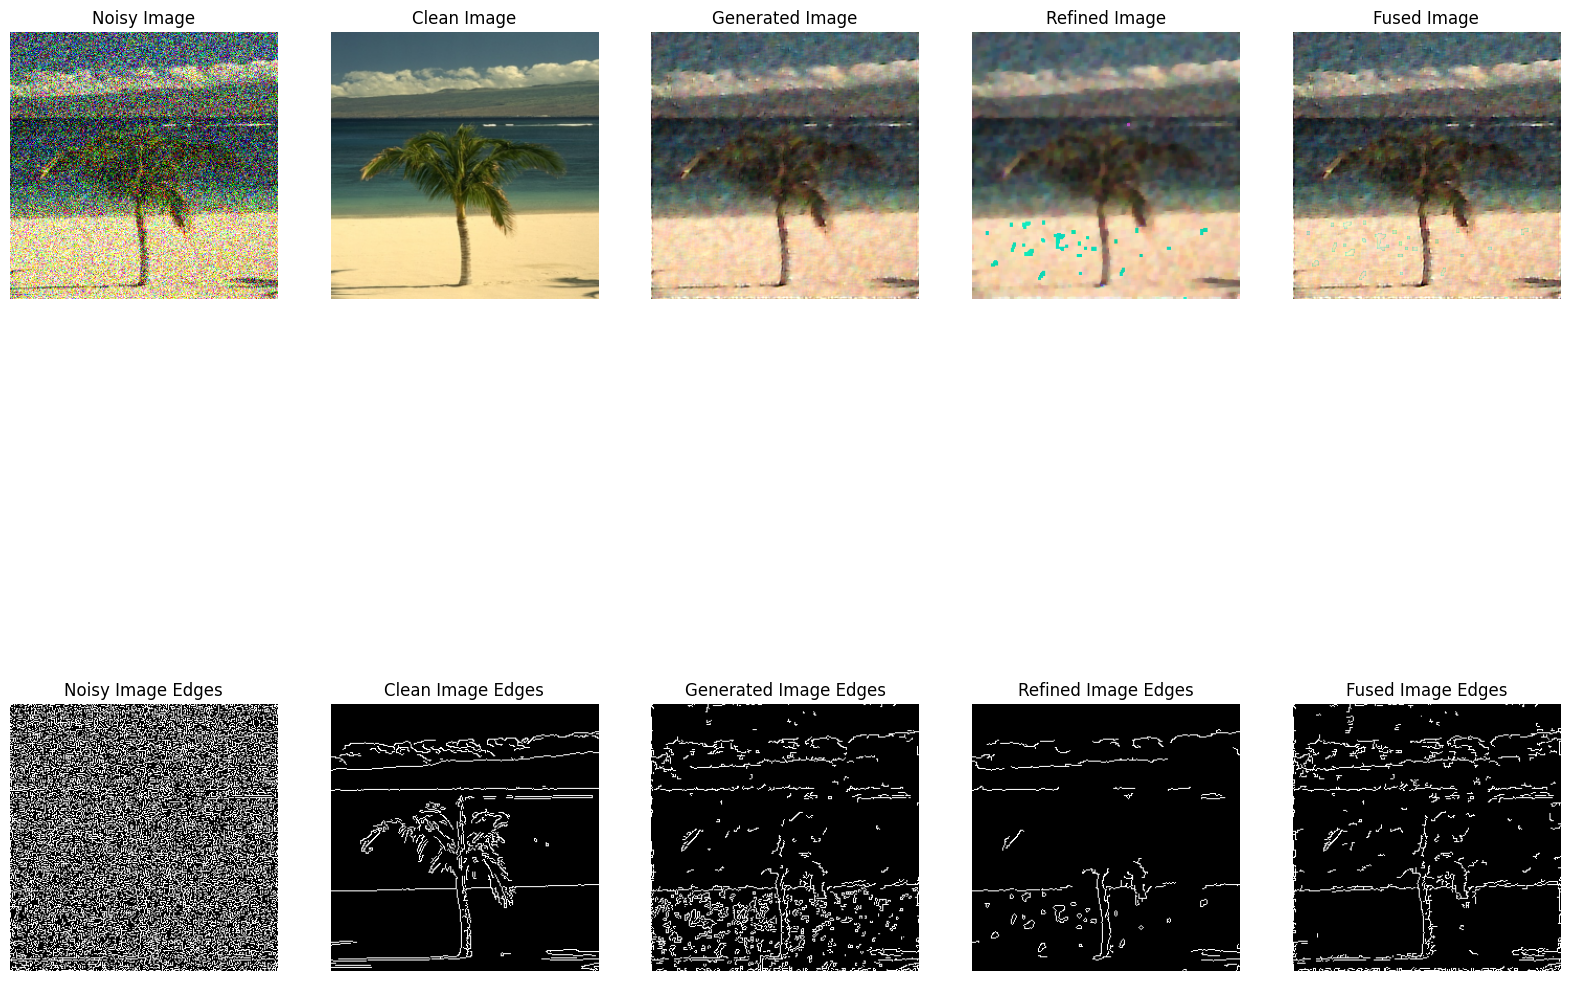

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4446145..1.2505172].


PSNR Noisy: 12.11, PSNR Generated: 22.70, PSNR Refined: 21.37, PSNR Fused: 22.28


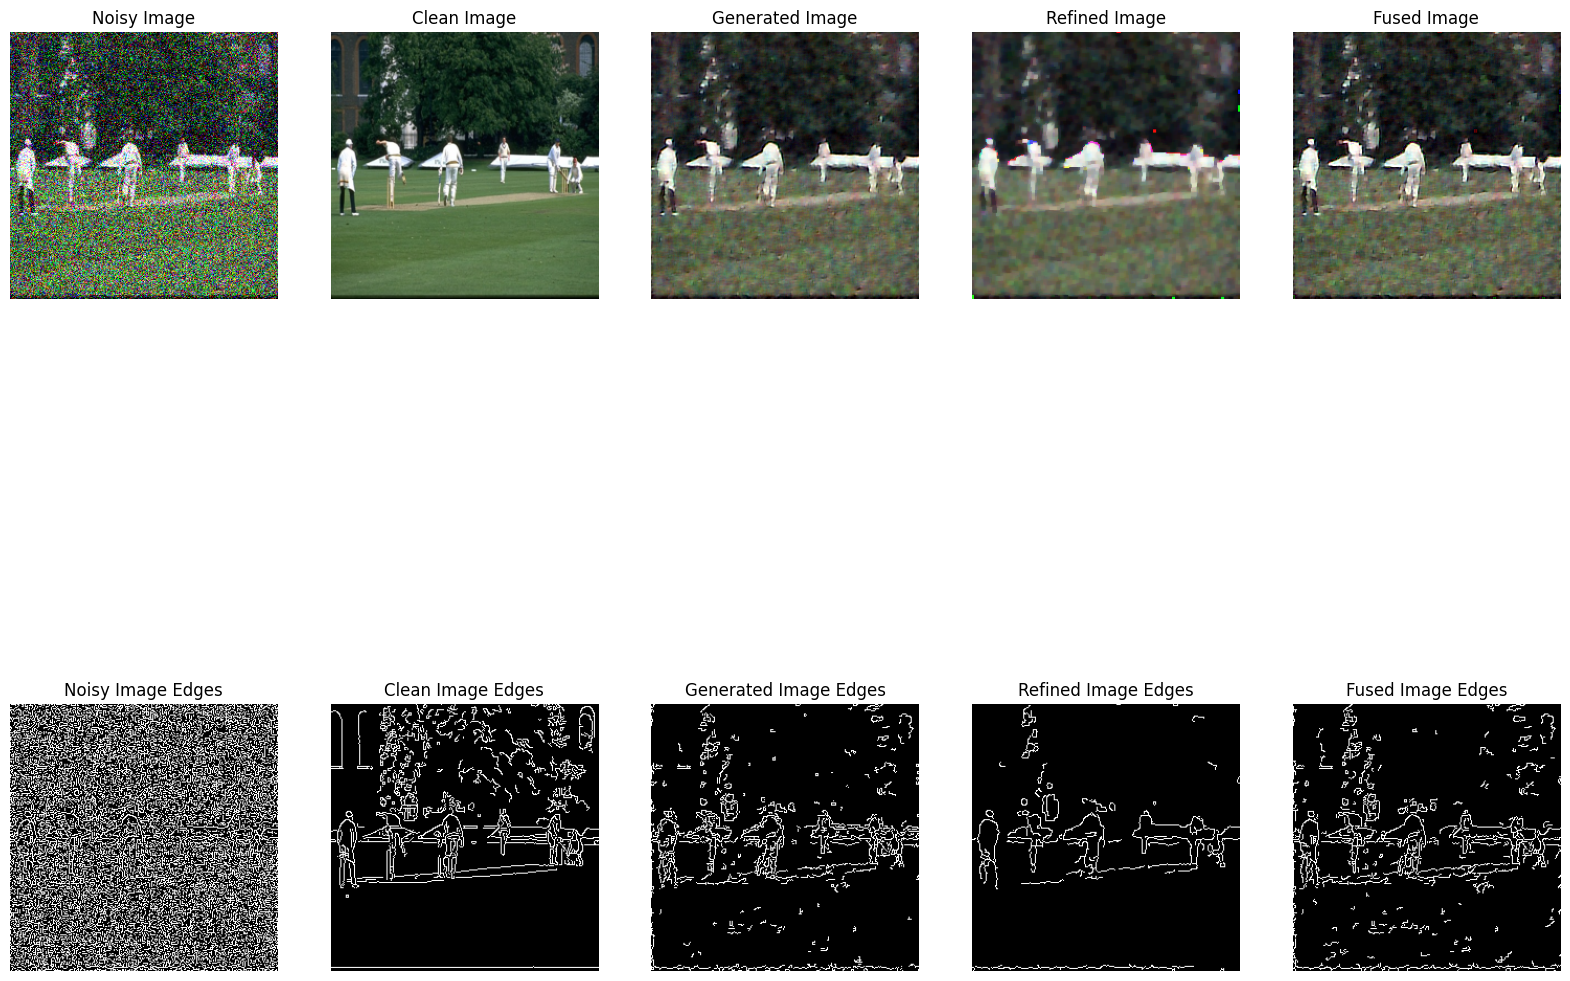

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24766955..1.2499166].


PSNR Noisy: 11.62, PSNR Generated: 22.93, PSNR Refined: 22.94, PSNR Fused: 22.20


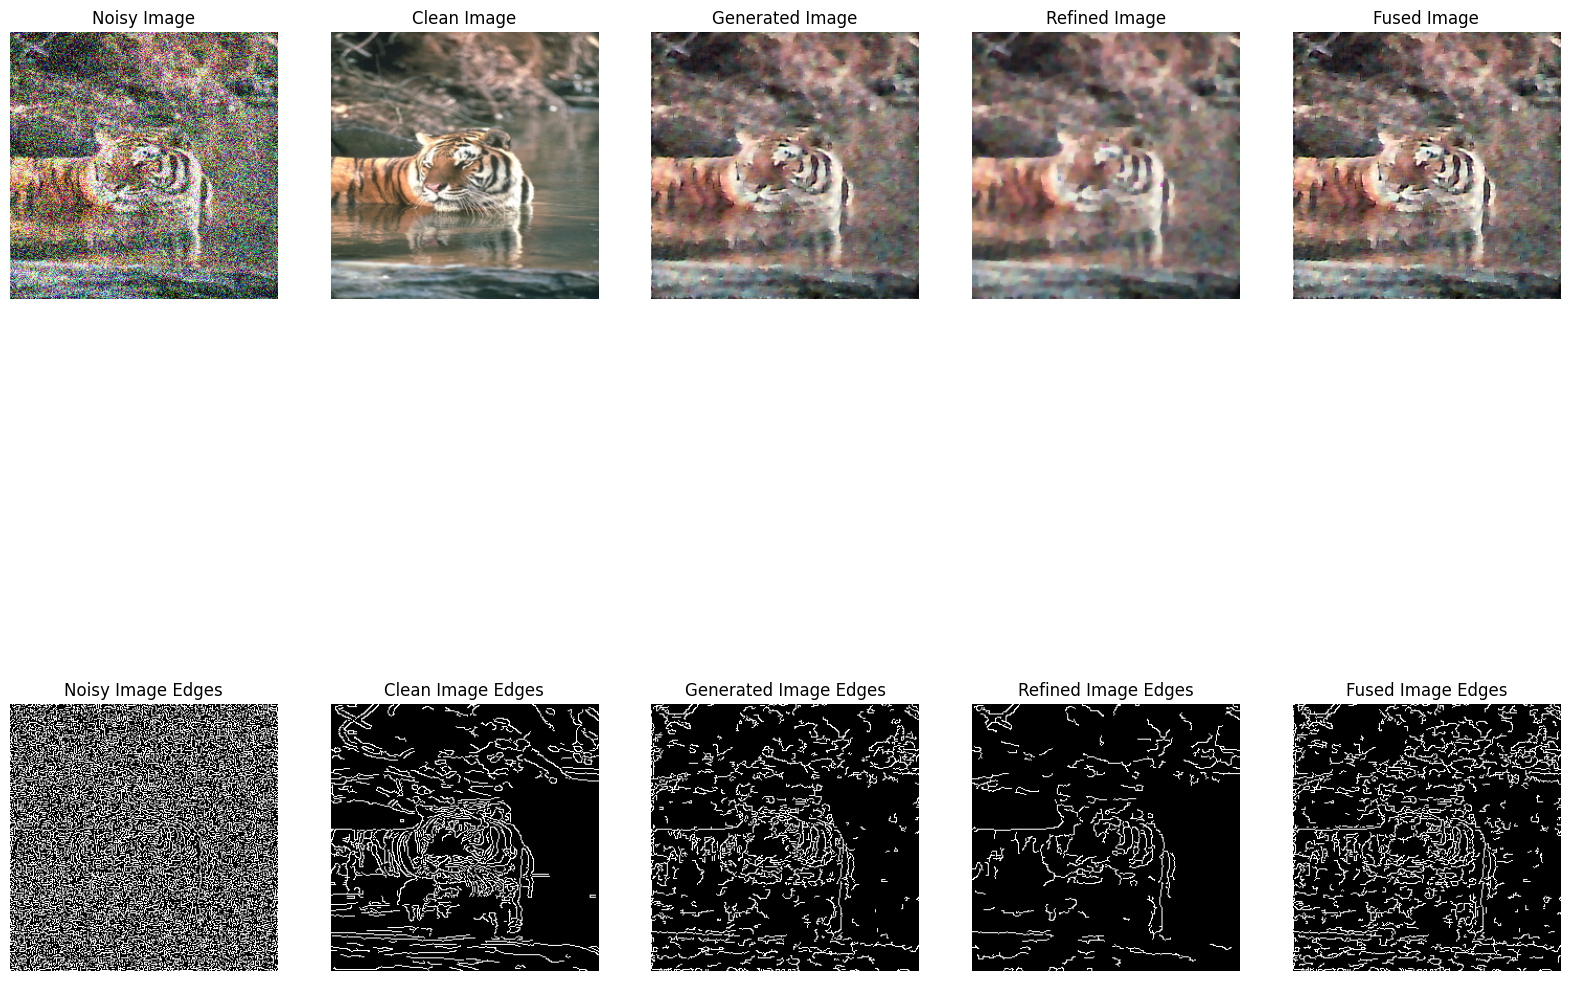

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.36420795..1.1265837].


PSNR Noisy: 11.93, PSNR Generated: 23.95, PSNR Refined: 23.58, PSNR Fused: 23.31


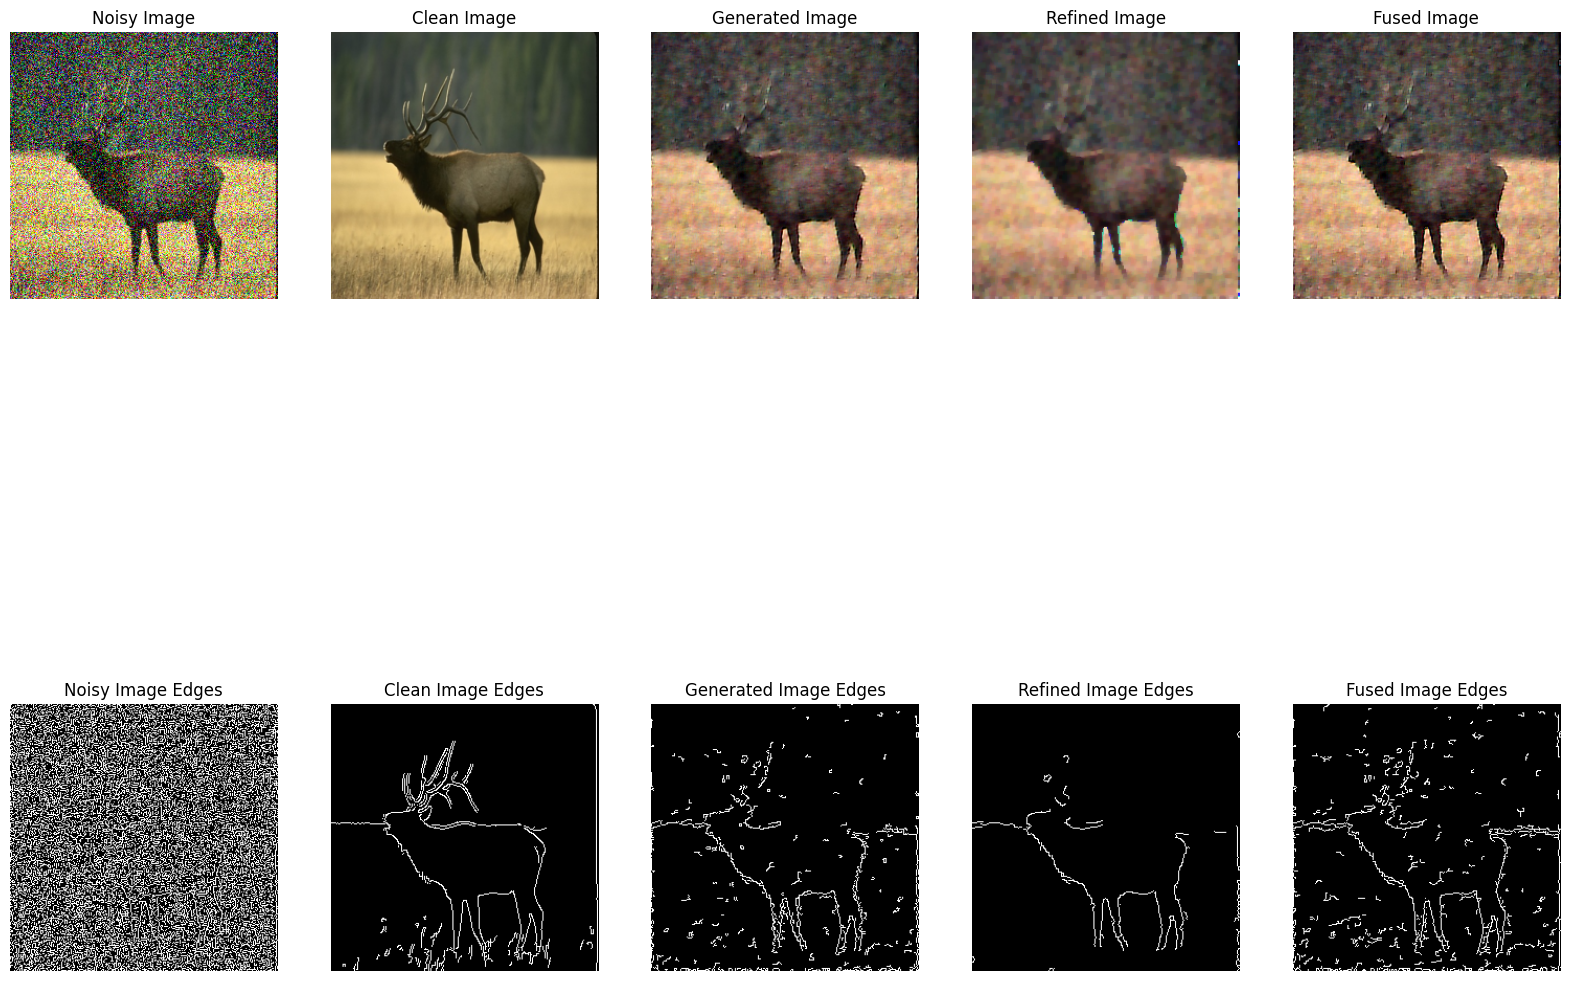

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05128822..1.1362793].


PSNR Noisy: 11.99, PSNR Generated: 23.62, PSNR Refined: 24.48, PSNR Fused: 23.21


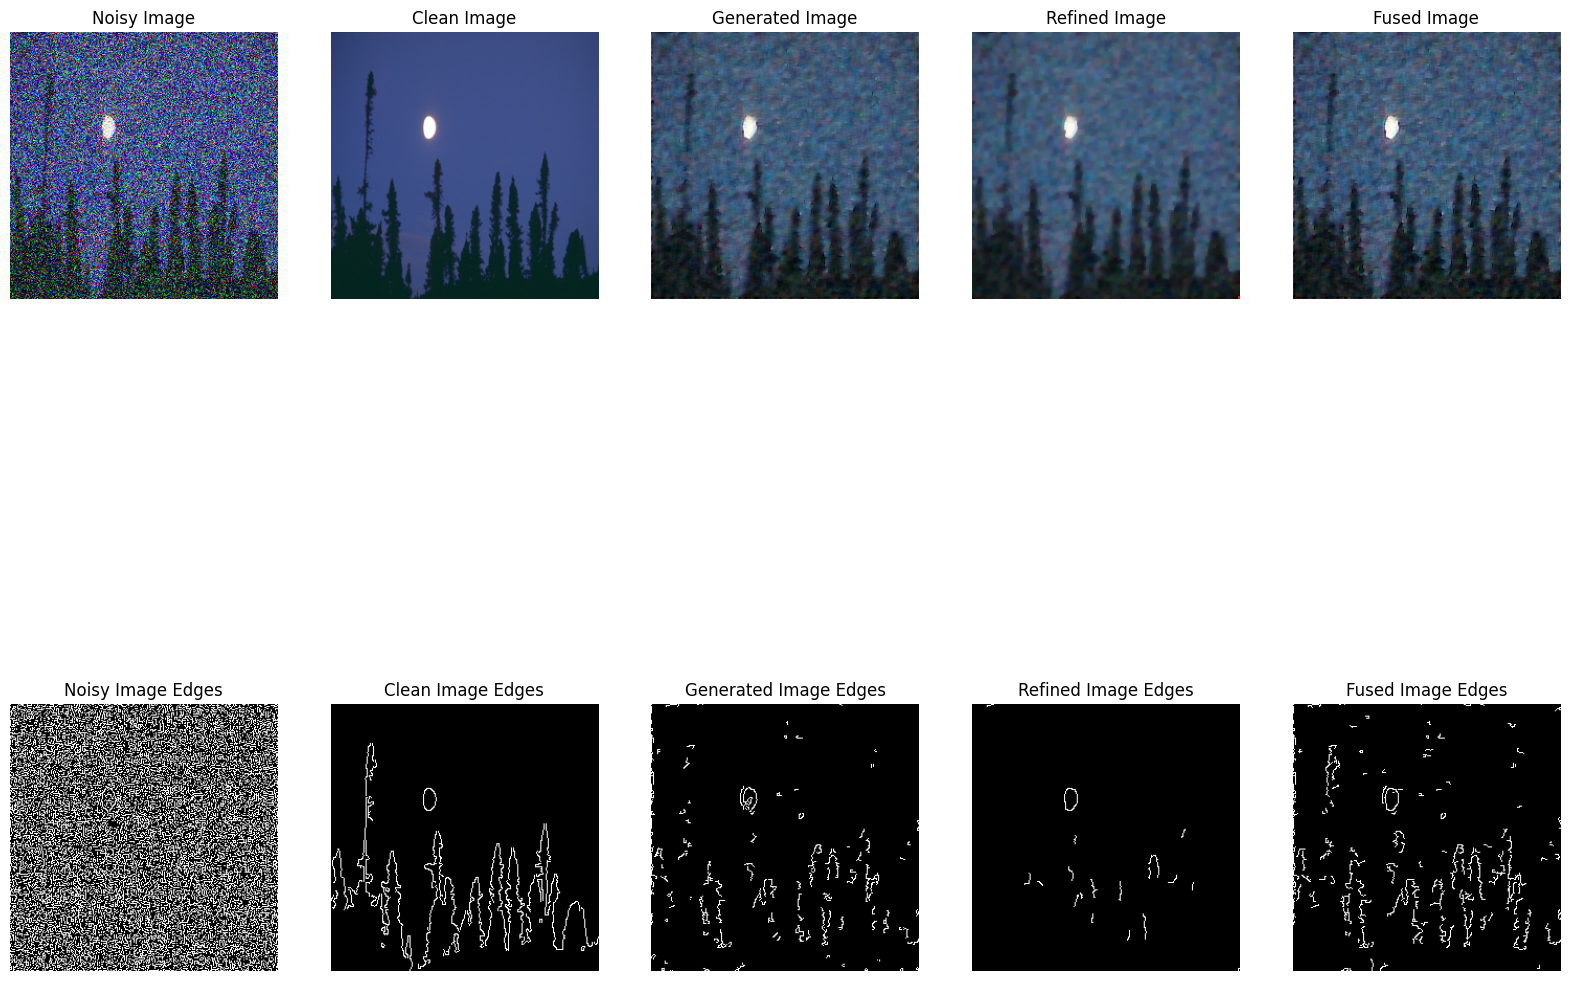

In [16]:
# Fonction pour appliquer plusieurs cycles de fermeture et ouverture sur chaque composante RGB
def apply_multiple_morphology_operations(generated_image, iterations=20):
    generated_np = generated_image.permute(1, 2, 0).cpu().numpy() * 255
    transformed_np = np.copy(generated_np)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    for _ in range(iterations):
        for i in range(3):
            channel = transformed_np[:, :, i].astype(np.uint8)
            channel_closed = cv2.morphologyEx(channel, cv2.MORPH_CLOSE, kernel)
            channel_opened = cv2.morphologyEx(channel_closed, cv2.MORPH_OPEN, kernel)
            transformed_np[:, :, i] = channel_opened

    return torch.tensor(transformed_np / 255.0).permute(2, 0, 1)


# Fonction pour fusionner avec les hautes fréquences
def fuse_with_high_frequencies(base_image, refined_image):
    base_np = base_image.permute(1, 2, 0).cpu().numpy() * 255
    refined_np = refined_image.permute(1, 2, 0).cpu().numpy() * 255

    refined_blur = cv2.GaussianBlur(refined_np, (5, 5), 0)
    high_freq = refined_np - refined_blur
    fused_np = np.clip(base_np + high_freq, 0, 255)

    return torch.tensor(fused_np / 255.0).permute(2, 0, 1)


# Fonction pour détecter les contours avec Canny
def detect_canny_edges(image):
    image_np = image.permute(1, 2, 0).cpu().numpy() * 255
    image_gray = cv2.cvtColor(image_np.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(image_gray, threshold1=100, threshold2=200)
    return torch.tensor(edges / 255.0).unsqueeze(0)


# Fonction d'affichage
def show_sample_with_metrics(generator, dataset, index, iterations=3):
    generator.eval()

    noisy_img, clean_img = dataset[index]
    noisy_img = noisy_img.unsqueeze(0).to(device)
    clean_img = clean_img.unsqueeze(0).to(device)

    with torch.no_grad():
        generated_img = generator(noisy_img)

    refined_img = apply_multiple_morphology_operations(generated_img.squeeze(), iterations=iterations)
    fused_img = fuse_with_high_frequencies(generated_img.squeeze(), refined_img)

    noisy_edges = detect_canny_edges(noisy_img.squeeze())
    clean_edges = detect_canny_edges(clean_img.squeeze())
    generated_edges = detect_canny_edges(generated_img.squeeze())
    refined_edges = detect_canny_edges(refined_img)
    fused_edges = detect_canny_edges(fused_img)

    # Calcul des PSNR
    psnr_noisy = psnr(clean_img.squeeze().permute(1, 2, 0).cpu().numpy(), noisy_img.squeeze().permute(1, 2, 0).cpu().numpy())
    psnr_generated = psnr(clean_img.squeeze().permute(1, 2, 0).cpu().numpy(), generated_img.squeeze().permute(1, 2, 0).cpu().numpy())
    psnr_refined = psnr(clean_img.squeeze().permute(1, 2, 0).cpu().numpy(), refined_img.permute(1, 2, 0).cpu().numpy())
    psnr_fused = psnr(clean_img.squeeze().permute(1, 2, 0).cpu().numpy(), fused_img.permute(1, 2, 0).cpu().numpy())

    print(f"PSNR Noisy: {psnr_noisy:.2f}, PSNR Generated: {psnr_generated:.2f}, PSNR Refined: {psnr_refined:.2f}, PSNR Fused: {psnr_fused:.2f}")

    plt.figure(figsize=(20, 16))

    images = [
        (noisy_img, noisy_edges, "Noisy Image"),
        (clean_img, clean_edges, "Clean Image"),
        (generated_img, generated_edges, "Generated Image"),
        (refined_img, refined_edges, "Refined Image"),
        (fused_img, fused_edges, "Fused Image"),
    ]

    for i, (image, edge, title) in enumerate(images):
        plt.subplot(2, 5, i + 1)
        plt.title(title)
        plt.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
        plt.axis('off')

        plt.subplot(2, 5, i + 6)
        plt.title(f"{title} Edges")
        plt.imshow(edge.squeeze().cpu().numpy(), cmap='gray')
        plt.axis('off')

    plt.show()


# Exemple d'affichage
for idx in range(5):  # Affiche les 5 premiers échantillons
    show_sample_with_metrics(generator, train_dataset, idx, iterations=3)
